In [3]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, Image, display
%matplotlib inline

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss, pplx = 0, 0
  # forward pass
  for t in range(len(inputs)):
    # encode in 1-of-k representation
    xs[t] = np.zeros((vocab_size,1))
    xs[t][inputs[t]] = 1

    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
    ys[t] = np.dot(Why, hs[t]) + by
    # softmax
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

    # cross-entropy loss
    loss += -np.log(ps[t][targets[t],0])
    # perplexity
    pplx += -np.log2(ps[t][targets[t],0])

  pplx = 2 ** (pplx / len(inputs))

  # backward pass: compute gradients going backwards
  # memory variables for derivatives
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    
    # backprop. into y
    # dLoss = y - t
    dy[targets[t]] -= 1
    # compute grad. w.r.t. Why
    dWhy += np.dot(dy, hs[t].T)
    # grad. w.r.t. by
    dby += dy

    # backprop into h
    # dh = Why^t * dy_t + dh_t+1
    dh = np.dot(Why.T, dy) + dhnext
    # backprop through tanh nonlinearity (f^\prime(z) = 1-tanh^2(z))
    dhraw = (1 - hs[t] * hs[t]) * dh
    dbh += dhraw

    # compute grad. w.r.t. Wxh, Whh
    # backprop into dh_t-1
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    dparam = np.clip(dparam, -1, 1) # clip to mitigate exploding gradients
    
  return loss, pplx, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  generated_seq = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    generated_seq.append(ix)
  return generated_seq

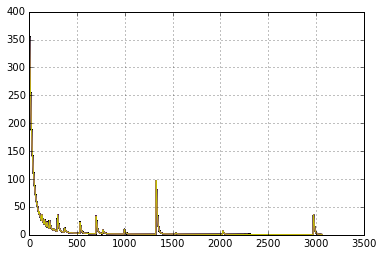

KeyboardInterrupt: 

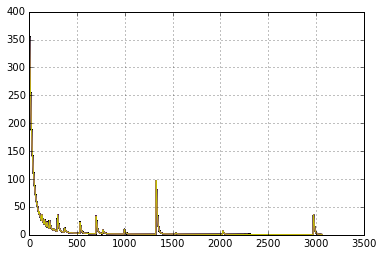

In [4]:
if __name__ == '__main__':

  #import pdb; pdb.set_trace()
  # data I/O
  data = open('data/lstm_from_wiki.txt', 'r').read() # should be simple plain text file
  #data = open('data/text8', 'r').read() # should be simple plain text file
  #data = open(str(sys.argv[1]), 'r').read()
  chars = list(set(data))
  print '%d unique characters in data.' % (len(chars))
  vocab_size = len(chars)
  data_size = len(data)
  char_to_ix = { ch:i for i,ch in enumerate(chars) }
  ix_to_char = { i:ch for i,ch in enumerate(chars) }

  # hyperparameters
  # size of hidden layer of neurons
  hidden_size = 256
  # number of steps to unroll the RNN for
  seq_length = 96
  # nb. of sequence to generate from model
  seq_length_sample = 128
  learning_rate = 0.01

  # model parameters
  Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
  Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
  Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
  bh = np.zeros((hidden_size, 1)) # hidden bias
  by = np.zeros((vocab_size, 1)) # output bias

  n, p, cum_p = 0, 0, 0
  # memory variables for momentum
  mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  # memory variables for Adagrad
  mbh, mby = np.zeros_like(bh), np.zeros_like(by)
  # compute initial loss (loss at iter. 0)
  smooth_loss = -np.log(1.0/vocab_size)*seq_length
  # variables for learning curve
  L = np.zeros((1000000,1), dtype=np.float32); plt.ion(); plt.show()

  # start to train
  while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
      # reset RNN memory
      hprev = np.zeros((hidden_size,1))
      p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets= [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    #if n % 100 == 0:
      #sample_ix = sample(hprev, inputs[0], seq_length_sample)
      #txt = ''.join(ix_to_char[ix] for ix in sample_ix)
      #print '----\n %s \n----' % (txt, )

    # forward seq_length characters through the net and fetch gradient
    loss, pplx, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)

    # accmulate loss
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    
    # print learning
    if n % 100 == 0:
      clear_output(wait=True)
      L[n/100] = smooth_loss; plt.plot(L[:n/100+1]); plt.grid(True)
      display(plt.gcf())
      #print 'epoch: (%d=%d/%d), iter %d, loss: %f, smooth_loss: %f, pplx: %f' % (cum_p / data_size, cum_p, data_size, n, loss, smooth_loss, pplx)
      #clear_output(wait=True)
        
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], [dWxh, dWhh, dWhy, dbh, dby], [mWxh, mWhh, mWhy, mbh, mby]):
      mem += dparam*dparam
      param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    cum_p += seq_length # cumulate
    n += 1 # iteration counter
    